In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [7]:
from collections import defaultdict
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

from bgspy.theory import bgs_rec, bgs_segment, bgs_segment_sc16, bgs_segment_sc16_manual_vec
from bgspy.parallel import MapPosChunkIterator
from bgspy.genome import Genome

In [8]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

In [6]:
bgs_segment_sc16(1e-8, 1e-5, 1000, 1e-4, 1000, full_output=True)

/home/vsb/projects/bprime/bgspy/theory.py:58: RuntimeWarning: divide by zero encountered in log
  np.log(N * np.exp(-V*Q2)) - np.log(Ne)]


(array([9.90033333e-06, 1.00000000e+03]),
 array({'nfev': 15, 'fjac': array([[nan, nan],
        [nan, nan]]), 'r': array([nan, nan, nan]), 'qtf': array([nan, nan]), 'fvec': array([  0., -inf])},
       dtype=object),
 array(5),
 array('The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.',
       dtype='<U106'))

In [ ]:
mu = np.logspace(-9, -7, 3)[:, None, None]
sh = np.logspace(-5, -1, 4)[None, :, None]

sc16 = bgs_segment_sc16(mu, sh, [1000, 1000, 1000], [1e-8, 1e-8, 1e-8], 1000)

In [ ]:
sc16.shape

## Testing Vectorization

In [ ]:
mu = np.logspace(-9, -7, 10)[:, None, None]
sh = np.logspace(-5, -1, 11)[None, :, None]

n = 1000
L = np.random.randint(1, 100, n)
rbp = np.random.uniform(1e-9, 1e-7, n)
            

vec = np.prod(bgs_segment_sc16(mu, sh, L, rbp, 1000), axis=2)
manual = np.prod(bgs_segment_sc16_manual_vec(mu, sh, L, rbp, 1000), axis=2)
np.allclose(vec, manual)

## Experimenting with Interpolation

In [103]:
from scipy.interpolate import interp2d, interp1d

def interpolate_bgs_sc16(mu, sh, L, rf, N):
    interpols = dict()
    nmu, nsh = len(mu), len(sh)
    L_grid, rf_grid = np.meshgrid(L, rf)
    L_grid, rf_grid = L_grid.squeeze(), rf_grid.squeeze()
    mu_grid, sh_grid = np.meshgrid(mu, sh)
    for i, m in enumerate(mu):
        for j, s in enumerate(sh):
            z = bgs_segment_sc16(m, s, L_grid, rf_grid, N)
            #key = (float(m), float(s))
            key = (i, j)
            interpols[key] = np.vectorize(interp2d(L_grid, rf_grid, z, kind='cubic'))
    def func(L, rf):
        if not isinstance(L, np.ndarray):
            L = np.array(L)
        if not isinstance(rf, np.ndarray):            
            rf = np.array(rf)
        n = max(L.size, rf.size)
        if L.size != rf.size:
            assert L.size == 1 or rf.size == 1, "cannot broadcast L and rf!"        
        res = np.empty((nmu, nsh, n))
        for (i, j), interpol in interpols.items():
            res[i, j, :] = interpol(L, rf)
        return res
    return func


mu = np.logspace(-9, -7, 10)
sh = np.logspace(-5, -1, 4)
L = np.linspace(1, 1000, 10).astype(int).astype(float)
rf = np.logspace(-12, -7, 10)

t = interpolate_bgs_sc16(mu, sh, L, rf, 1000)

/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points m.
Probable causes: either s or m too small. (fp>s)
	kx,ky=3,3 nx,ny=17,12 m=100 fp=0.168706 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=16,9 m=100 fp=0.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))
/home/vsb/miniconda3/envs/bprime/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:977: RuntimeWarning: No more knots can be added because the number of B-spline
coefficients already exceeds the number of data points

In [104]:
rf

array([1.00000000e-12, 3.59381366e-12, 1.29154967e-11, 4.64158883e-11,
       1.66810054e-10, 5.99484250e-10, 2.15443469e-09, 7.74263683e-09,
       2.78255940e-08, 1.00000000e-07])

[]

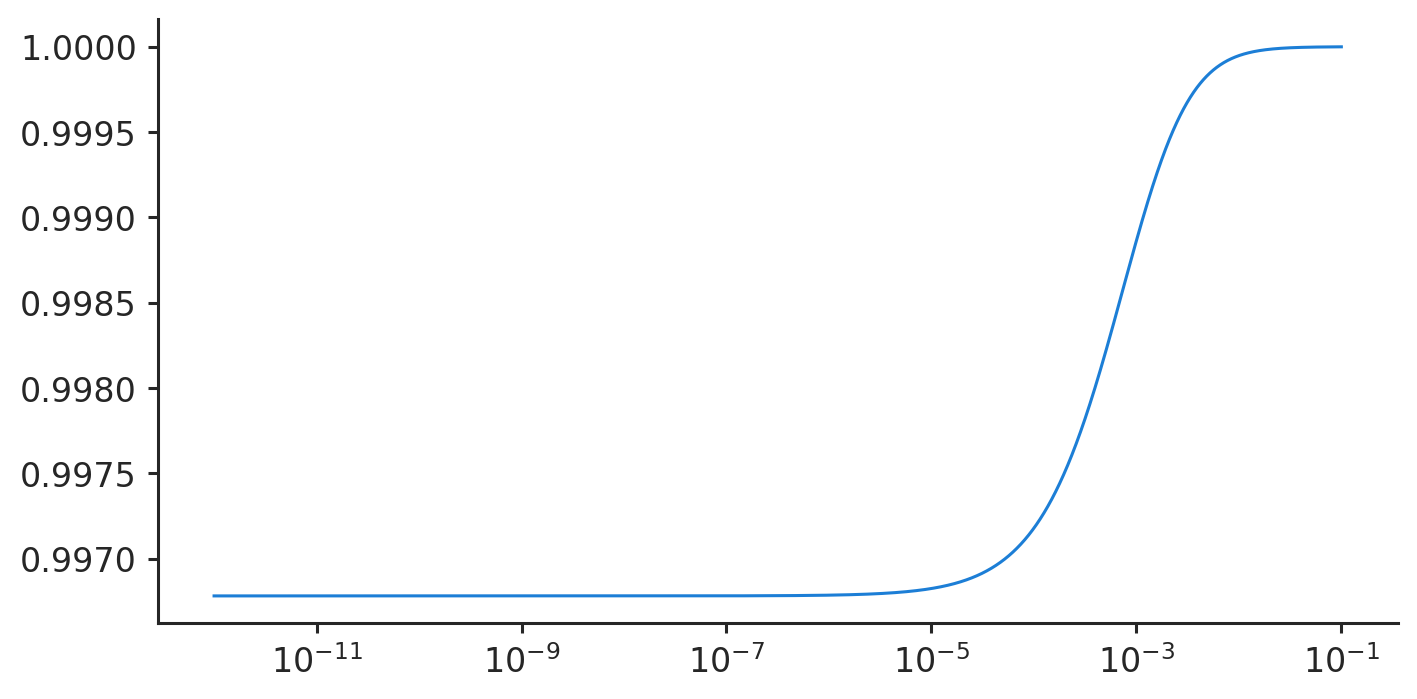

In [120]:
rf = np.logspace(-12, -1, 10000)
plt.plot(rf, bgs_segment_sc16(1e-8, 1e-3, 1000, rf, 1000))
plt.semilogx()

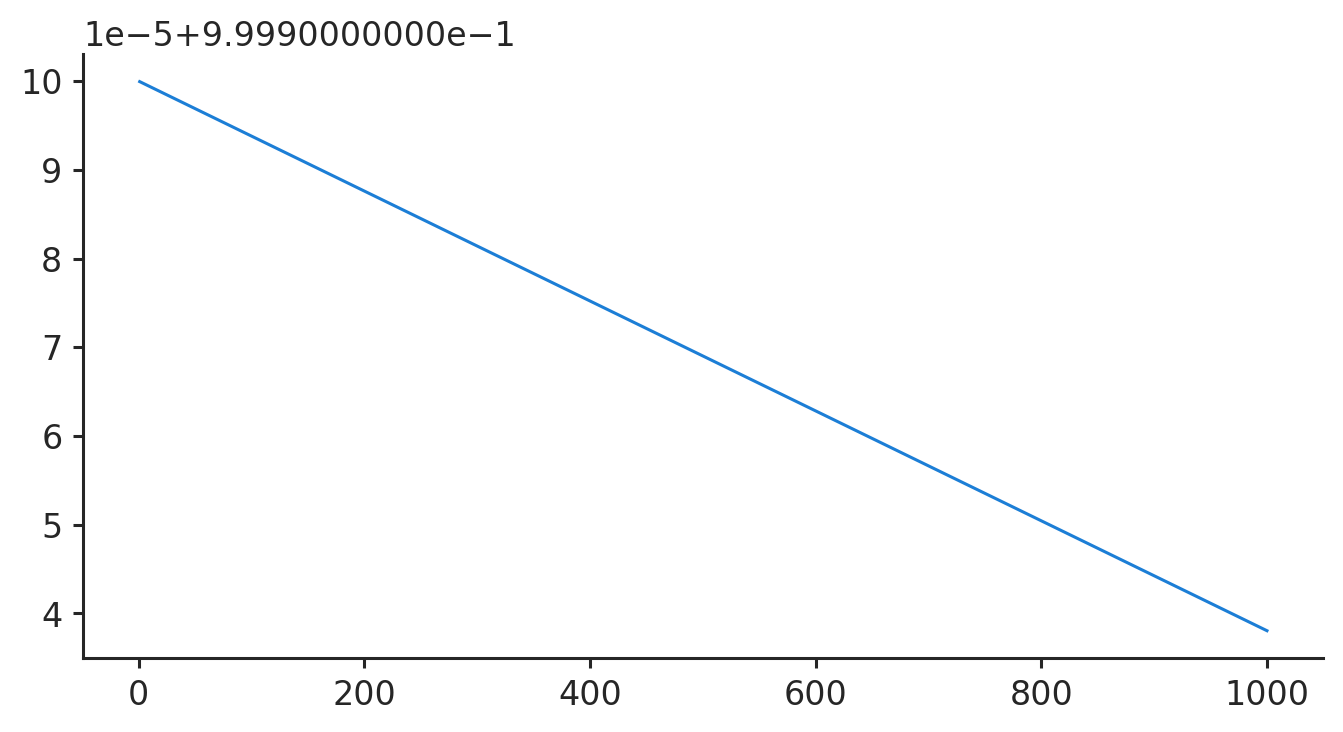

In [106]:
L = np.linspace(1, 1000, 100)

plt.plot(L, t(L, 1e-8)[1, 1, :])

In [ ]:
L = np.linspace(1, 1000, 100)

plt.plot(L, t(L, 1e-8)[1, 1, :])

In [72]:
sc16_interpol = interpolate_bgs_sc16(mu, sh, np.linspace(1, 1000, 100).astype(int), np.logspace(-12, -7, 11), N=1000)

In [73]:
%%timeit

sc16_interpol(1000, 1e-8)

147 µs ± 937 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [74]:
%%timeit

bgs_segment_sc16(mu, sh[:, None], 1000, 1e-8, N=1000)

2.02 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [75]:
res_interpol = sc16_interpol(1000, 1e-8)
res_manual = bgs_segment_sc16(mu[:, None], sh, 1000, 1e-8, N=1000)
res_interpol, res_manual

(array([[0.9999999 , 0.99996286, 0.99978514, 0.99999   ],
        [0.99999901, 0.99962902, 0.99785356, 0.99990001],
        [0.9999901 , 0.99633012, 0.9787512 , 0.9990005 ]]),
 array([[0.9999999 , 0.99996286, 0.99978514, 0.99999   ],
        [0.99999901, 0.99962902, 0.99785356, 0.99990001],
        [0.9999901 , 0.99633012, 0.9787512 , 0.9990005 ]]))

In [36]:
sc16_interpol(1000, 1e-8)

array([[0.9999999 , 0.99999901, 0.9999901 , 0.99996286],
       [0.99962902, 0.99633012, 0.99978514, 0.99785356],
       [0.9787512 , 0.99999   , 0.99990001, 0.9990005 ]])

In [19]:
g = Genome('hg38', seqlens_file="../data/annotation/hg38_seqlens.tsv", chroms=['chr10'])
g.load_annot("../data/annotation/conserved_by_chrom/chr10.bed")
g.load_recmap("../data/annotation/hapmap/genetic_map_GRCh37_chr10.txt")
g.create_segments(split_length=10_000)
g
chunks = MapPosChunkIterator(g,  mu.squeeze(), sh.squeeze(), 1000, 5000)

ignoring HapMap header...
parsing recmap as HapMap formatted (chrom, end, rate)
completed segmenting chr10.
looking up map positions...	done.


In [20]:
chunk = next(chunks)

In [22]:
res = calc_B_SC16_chunk_worker(chunk)

/home/vsb/projects/bprime/bgspy/theory.py:50: RuntimeWarning: invalid value encountered in log
  return [np.log((np.exp(2*sh*Ne) - 1)/(2*U*sh*Ne)) - np.log(T),
/home/vsb/projects/bprime/bgspy/theory.py:56: UserWarning: no solution found!
  warnings.warn("no solution found!")


In [29]:
res[0].prod(axis=2)

array([[9.98018565e-01, 4.74764058e-01, 1.25745113e-02, 8.15027354e-01],
       [9.86206794e-01, 5.46737430e-03, 4.13402564e-14, 2.36296205e-01],
       [5.93488549e-01, 8.40677729e-80,            nan,            nan]])

In [30]:
np.exp(np.log(res[0]).sum(axis=2))

array([[9.98018565e-01, 4.74764058e-01, 1.25745113e-02, 8.15027354e-01],
       [9.86206794e-01, 5.46737430e-03, 4.13402564e-14, 2.36296205e-01],
       [5.93488549e-01, 8.40677729e-80,            nan,            nan]])

In [36]:
(res[0][1, 2, :]).shape

(6239,)

In [40]:
res[1][2, 2]

array([0.93238786, 0.9518603 ,        nan, ..., 0.99994065, 0.99997858,
       0.99986784])

(0.993, 1.002)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica, Arial


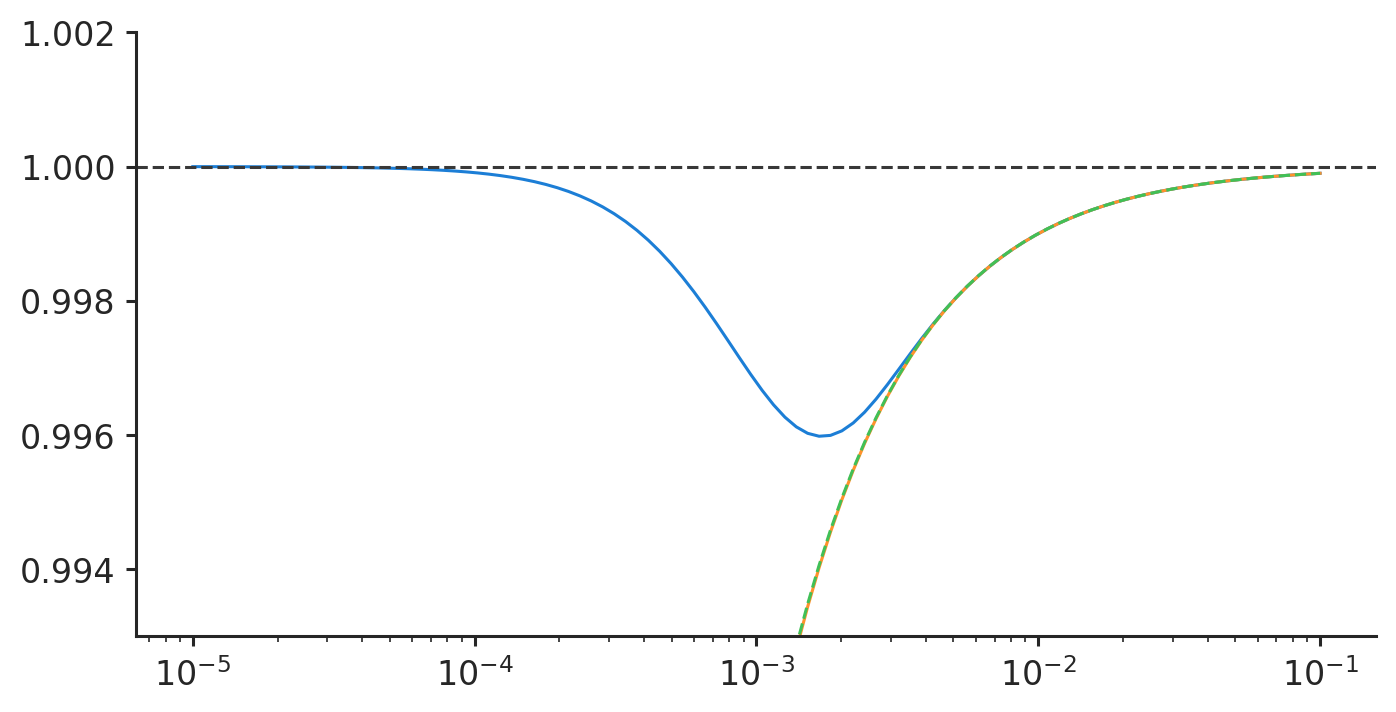

In [5]:
mu = 1e-8
rf = 0.001
rf = 1e-8
sh = np.logspace(-5, -1, 100)
L = 1000
N = 1000
sc16 = bgs_segment_sc16(mu, sh, L, rf, N)

plt.plot(sh, sc16)
plt.plot(sh, bgs_rec(mu, sh, L, rf))
plt.plot(sh, bgs_segment(mu, sh, L, 1e-8, rf), linestyle='dashed')

plt.semilogx()
plt.axhline(1, linestyle='dashed', c='0.22')
#plt.ylim(np.nanmin(sc16)*0.999, 1.0002)
plt.ylim(0.993, 1.002)